In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

## Подготовка данных

In [2]:
df = pd.read_csv('athletes.csv')

In [3]:
df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


Видно, что есть записи с пропусками, уберем такие записи

In [5]:
df = df[~(df.height.isna() | df.weight.isna() | df.dob.isna())]

Преобразуем столбец dob в три столбца dob1, dob2, dob3

In [6]:
df = df.join(df.dob.str.split('/', n=2, expand=True).rename(columns={0: 'dob1', 1: 'dob2', 2: 'dob3'}))

In [7]:
for column in ['dob1', 'dob2', 'dob3']:
    df[column] = df[column].astype(int)

Добавим целевой target столбец, который будем значить, заработал ли спортсмен хоть какую-либо медаль

In [8]:
df['has_medal'] = (df.gold.astype(bool) | df.silver.astype(bool) |  df.bronze.astype(bool)).astype(int)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10858.0,5.011329e+08,2.909399e+08,18347.00,2.460081e+08,5.020973e+08,7.555681e+08,9.999878e+08
height,10858.0,1.766942e+00,1.131113e-01,1.21,1.690000e+00,1.760000e+00,1.840000e+00,2.210000e+00
weight,10858.0,7.207092e+01,1.616236e+01,31.00,6.000000e+01,7.000000e+01,8.100000e+01,1.700000e+02
gold,10858.0,5.977160e-02,2.607561e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
silver,10858.0,5.848223e-02,2.423868e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
bronze,10858.0,5.857432e-02,2.391125e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
dob1,10858.0,6.282833e+00,3.425605e+00,1.00,3.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01
dob2,10858.0,1.563631e+01,8.799700e+00,1.00,8.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01
dob3,10858.0,8.871348e+01,8.172789e+00,0.00,8.600000e+01,9.000000e+01,9.300000e+01,9.900000e+01
has_medal,10858.0,1.614478e-01,3.679604e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [10]:
df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,dob1,dob2,dob3,has_medal
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0,10,17,69,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0,9,23,86,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1,5,27,92,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0,1,2,91,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0,11,26,90,0


## Разделение данных на train, test части

In [11]:
selected_df = df[['height', 'weight', 'dob1', 'dob2', 'dob3', 'nationality', 'sex', 'sport']]
X = pd.get_dummies(selected_df, columns=['nationality', 'sex', 'sport'])
Y = df['has_medal']

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
pipe =  LogisticRegression()

In [14]:
pipe.fit(X_train, Y_train)

LogisticRegression()

## Построение ROC-кривой с помощью функции sklearn.metrics roc_curve

In [15]:
predict_proba_values = pipe.predict_proba(X_test)
predictions = pipe.predict(X_test)

In [16]:
fpr, tpr, thres = roc_curve( Y_test, predict_proba_values[:, 1] )

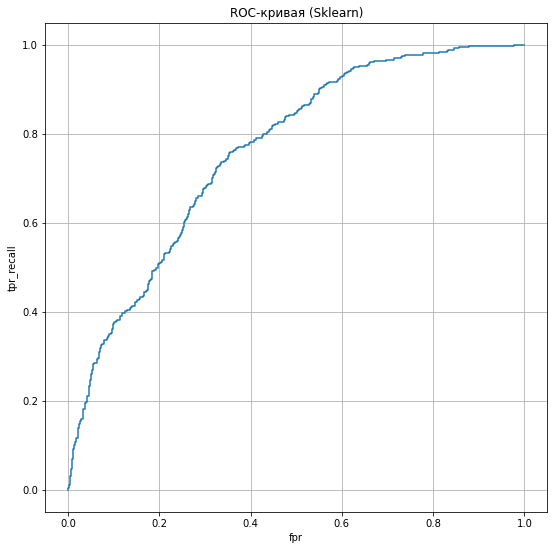

In [17]:
plt.figure(figsize=(9, 9))
plt.plot(fpr, tpr)
plt.title('ROC-кривая (Sklearn)')
plt.xlabel('fpr')
plt.ylabel('tpr_recall')
plt.grid()

## Вычисление значения ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score

In [18]:
roc_auc_score( Y_test, predict_proba_values[:, 1])

0.7606791980678249

## Подсчет метрик TPR, FPR вручную

### Подготовим разные пороговые значения `ratio`

In [19]:
step = 0.02
ratios = np.arange(0.0, 1.0 + step, step)

### Для каждого порогового значения `ratio` произведем подсчет метрик

In [20]:
ratio_metrics_dicts = []
for ratio in ratios:
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative
    for predicted_prob, actual in zip( predict_proba_values[:, 1], Y_test ):    
        if predicted_prob >= ratio:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1

        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    step_dict = {
        'ratio': ratio,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    }
    ratio_metrics_dicts.append(step_dict)

In [21]:
ratios_metrics = pd.DataFrame(ratio_metrics_dicts)

In [22]:
ratios_metrics['fpr'] = ratios_metrics['fp'] / (ratios_metrics['fp'] + ratios_metrics['tn'])
ratios_metrics['tpr_recall'] = ratios_metrics['tp'] / (ratios_metrics['tp'] + ratios_metrics['fn'])
ratios_metrics['precision'] =  ratios_metrics['tp'] / (ratios_metrics['tp'] + ratios_metrics['fp'])

### В результате получим датасет, с подсчитанными метриками для каждого порогового значения `ratio` от 0 до 1 с шагом 0.02

In [23]:
ratios_metrics.head()

,ratio,tp,fp,fn,tn,fpr,tpr_recall,precision
0,0.00,361,1811,0,0,1.000000,1.000000,0.166206
1,0.02,355,1490,6,321,0.822750,0.983380,0.192412
2,0.04,350,1319,11,492,0.728327,0.969529,0.209706
3,0.06,345,1191,16,620,0.657648,0.955679,0.224609
4,0.08,333,1073,28,738,0.592490,0.922438,0.236842


## Построение ROC-кривой с помощью вычисленных в п. 5 метрик

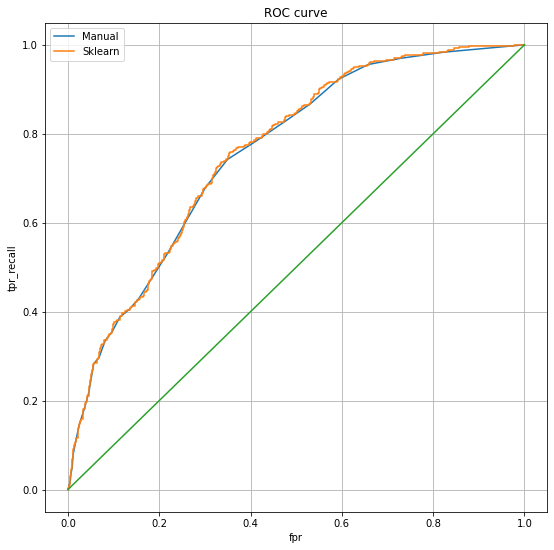

In [24]:
plt.figure(figsize=(9, 9))
plt.plot(ratios_metrics['fpr'], ratios_metrics['tpr_recall'], label='Manual')
plt.plot(fpr, tpr, label='Sklearn')
plt.plot([0.0, 1.0],[0.0, 1.0])
plt.xlabel('fpr')
plt.ylabel('tpr_recall')
plt.title('ROC curve')
plt.legend(loc=0)
plt.grid()

На графикие ROC-кривых можно видеть, что обе кривые повторяют друг друга с точностью до ratio step

## Построение графика Precision-Recall, используя метрики, посчитанные в п. 5.

In [25]:
precision, recall, threshold = precision_recall_curve( Y_test, predict_proba_values[:, 1])

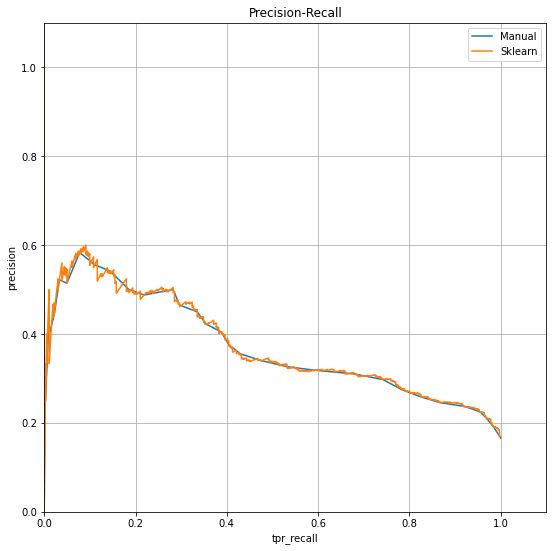

In [26]:
plt.figure(figsize=(9, 9))
plt.plot(ratios_metrics['tpr_recall'], ratios_metrics['precision'], label='Manual')
plt.plot(recall, precision, label='Sklearn')
plt.xlabel('tpr_recall')
plt.ylabel('precision')
plt.title('Precision-Recall')
plt.legend(loc=0)
plt.xlim(right=1.1, left=0)
plt.ylim(top=1.1, bottom=0)
plt.grid()

### Сравнение трех метрик, которые посчитаны вручную и через библиотеки sklearn

In [27]:
manual_metrics = ratios_metrics[ratios_metrics.ratio == 0.5].iloc[0]
tp, fp, fn, tn = manual_metrics['tp'], manual_metrics['fp'], manual_metrics['fn'], manual_metrics['tn'] 
tp, fp, fn, tn 

(18.0, 17.0, 343.0, 1794.0)

### Accuracy

In [28]:
manual_accuracy = (tp + tn) / (tp + fp + fn + tn)
manual_accuracy, pipe.score(X_test, Y_test)

(0.8342541436464088, 0.8342541436464088)

### Precision

In [29]:
manual_precision = tp / (tp + fp)
manual_precision, precision_score(Y_test, predictions)

(0.5142857142857142, 0.5142857142857142)

### Recall

In [30]:
manual_recall = tp / (tp + fn)
manual_recall, recall_score(Y_test, predictions)

(0.04986149584487535, 0.04986149584487535)

Видно, что метрики совпадают

## Выводы:

Наша модель показала хороший уровень `Accuracy` и неплохой ROC-AUC score, но средние  `Precision` и `Recall`. 
По полученным графикам делаем вывод о качестве модели так: чем выше площадь под кривой Precision-Recall тем модель лучше.
В нашем случае модель показывает средние показали качества - площадь под кривой. 
Для работы на предприятии или в промышленности такую модель необходимо дополнительно прорабатывать, поскольку результаты весьма скромные.